In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mat
import collections
import threading
import matplotlib.patches as mpatches
import time

In [16]:
class Vertex():

    def __init__(self,id,value,out_vertices):
        # This is mostly self-explanatory, but has a few quirks:
        #
        # self.id is included mainly because it's described in the
        # Pregel paper.  It is used briefly in the pagerank example,
        # but not in any essential way, and I was tempted to omit it.
        #
        # Each vertex stores the current superstep number in
        # self.superstep.  It's arguably not wise to store many copies
        # of global state in instance variables, but Pregel's
        # synchronous nature lets us get away with it.
        self.id = id 
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

In [17]:
class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()
        #time.sleep(10)
        #print(f" Worker completed superstep with vertices list : {[v.id for v in self.vertices]}")
        

    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()


In [18]:
class Pregel():

    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[self.worker(vertex)].append(vertex)
        return partition

    def worker(self,vertex):
        """Returns the id of the worker that vertex is assigned to."""
        return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep.  

        Note that in this implementation, worker threads are spawned,
        and then destroyed during each superstep.  This creation and
        destruction causes some overhead, and it would be better to
        make the workers persistent, and to use a locking mechanism to
        synchronize.  The Pregel paper suggests that this is how
        Google's Pregel implementation works."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            #print(f" Worker started with vertices list : {[v.id for v in vertex_list]}")
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertix,message) in vertex.outgoing_messages:
                receiving_vertix.incoming_messages.append((vertex,message))

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices])


In [19]:
class TrustRankVertex(Vertex):
    def __init__(self,id, value, out_vertices, mode=0, dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.mode = mode

    def update(self):
        # This routine has a bug when there are pages with no outgoing
        # links (never the case for our tests).  This problem can be
        # solved by introducing Aggregators into the Pregel framework,
        # but as an initial demonstration this works fine.

        #print(f"{self.id} Vertex Superstep : {self.superstep}" )

        # mode 0 - for calculating inverse page rank
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            outmessage_sum  = 0
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message
            for vertex in self.out_vertices:
                if not isinstance(vertex,TrustRankVertex):
                    print(f"\n===== Not Trust Rank - {str(vertex)} +++++ Type = {type(vertex)} ==========\n")
                #print(type(vertex))
                outmessage_sum = outmessage_sum+adj_mtx[self.id][vertex.id]
            self.value = (1-self.dampingFactor) * d[self.id] + self.dampingFactor*messages_sum
            outgoing_message = self.value / len(self.out_vertices)
            self.outgoing_messages = [(vertex,self.value*(adj_mtx[self.id][vertex.id]/outmessage_sum)) for vertex in self.out_vertices]
        else:
            self.active = False


In [20]:
num_workers = 4                                 # No of threads to assign vertices

def pregelTrustRank(vertices):
    pregel = Pregel(vertices, num_workers)
    pregel.run()
    return mat([(vertex.value, vertex.id) for vertex in pregel.vertices])


In [21]:

def intialPageRank(nodes):
    return [0.0 for n in nodes]


In [22]:
# Implementing the Algorithm
# Defining variables
# read csv data file
dataDF = pd.read_csv("Iron_dealers_data.csv")
# find unique number of buyer and seller ids
num_vertices = pd.unique(dataDF[['Buyer ID', 'Seller ID']].values.ravel('K')).size

# read bad nodes ID
badDF = pd.read_csv("bad.csv")
bad_nodes = []
for i in range(len(badDF)):
    bad_nodes.append(badDF.loc[i,'Bad Id'])

# dictionary of counter -> pregel nodes
pregelNodes = {}
# counter variable to map buyer and seller id starting from 0
counter = 0
# dictionary to store buyer/seller id -> counter
nodeMap = {}
# list to store pregel nodes
nodes = []

zero_deg = []

adj_mtx = [ [0]*num_vertices for i in range(num_vertices) ]

damping_factor = 0.85

for i in range(len(dataDF)):
    
    seller_id = dataDF.loc[i,'Seller ID']
    if seller_id not in nodeMap:
        p = TrustRankVertex(counter, 1, [], damping_factor)
        pregelNodes[counter] = p
        nodes.append(p)
        nodeMap[seller_id] = counter
        counter +=1
    else:
        p = pregelNodes[nodeMap[seller_id]]
    
    buyer_id = dataDF.loc[i,'Buyer ID']
    if buyer_id not in nodeMap:
        q = TrustRankVertex(counter, 1, [], 0, damping_factor)
        pregelNodes[counter] = q
        nodes.append(q)
        nodeMap[buyer_id] = counter
        counter +=1 
    else:
        q = pregelNodes[nodeMap[buyer_id]]

    edge_weight = dataDF.loc[i,'Value']
    # vertex_weight_list = [q, edge_weight]
    # append q along with the edge weight to p's out vertices
    # p.out_vertices.append(vertex_weight_list)
    p.out_vertices.append(q)
    adj_mtx[p.id][q.id] = edge_weight

# store all the zero degree vertices
for node in nodes:
    if len(node.out_vertices) == 0:
        zero_deg.append(node.id)

# map bad nodes id to counter id
for i in range(len(bad_nodes)):
    bad_nodes[i] = nodeMap[bad_nodes[i]]

for zi in zero_deg:
    for bn in bad_nodes:
        bad_node = pregelNodes[bn]
        if bad_node not in pregelNodes[zi].out_vertices:
            pregelNodes[zi].out_vertices.append(bad_node)
            adj_mtx[zi][bn] = 1

count = 0
d = intialPageRank(nodes)
for s in bad_nodes:
    count = count + 1
    d[s] = 1
for i in range(len(d)):
    d[i] = d[i]/count

node_ranks = pregelTrustRank(nodes)

# tr = TrustRank(damping_factor, max_iters, maxer, L, nodes_new, outlinks, inlinks)
# trust_scores = tr.trustRank()



In [23]:
print("\nTrust scores of all the nodes are as follows: ")
node_ranks_list = node_ranks.tolist()
for i in node_ranks_list:
    print(i, end=" ")
print("\n\n")
# Length of the list of trust scores
print("Length of the list of trust scores: ", len(node_ranks_list))


Trust scores of all the nodes are as follows: 
[0.01773004743544122, 0.0] [0.019461474562063832, 1.0] [0.008985595970337618, 2.0] [0.008985595970337618, 3.0] [0.014491267636245675, 4.0] [0.008985595970337618, 5.0] [0.018585738453916915, 6.0] [0.024770999482350148, 7.0] [0.00745843996466679, 8.0] [0.01856960668654465, 9.0] [0.008985595970337618, 10.0] [0.007637721042511057, 11.0] [0.008985595970337618, 12.0] [0.011287009711946393, 13.0] [0.008985595970337618, 14.0] [0.010974317787836935, 15.0] [0.044627217216593754, 16.0] [0.02161260267690745, 17.0] [0.008985595970337618, 18.0] [0.014733997562250217, 19.0] [0.009527341342157505, 20.0] [0.008985595970337618, 21.0] [0.018236656577343593, 22.0] [0.008985595970337618, 23.0] [0.0, 24.0] [0.0034269409373605454, 25.0] [0.010541108935311912, 26.0] [0.0012251912421702015, 27.0] [0.0019131425822530752, 28.0] [4.079280875376708e-06, 29.0] [0.0, 30.0] [5.628788553963557e-06, 31.0] [0.00022736066291335671, 32.0] [0.0, 33.0] [0.002623335236080364, 3

In [24]:
# sort noderanks in descending order by their first index
sortedcolumn = sorted(node_ranks_list,key=lambda x:x[0])
# print(sortedcolumn)

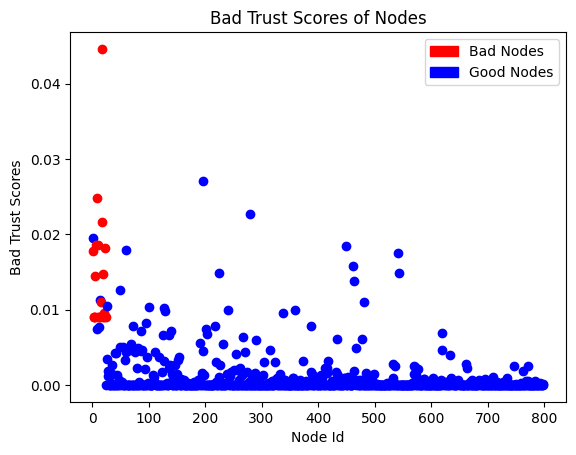

In [25]:
# Plotting the trust ranks if bad node then red else blue
count=0
for i in node_ranks_list:
    count = count + 1
    if i[1] in bad_nodes:
        plt.scatter(count, float(i[0]), color = 'red')
    else:
        plt.scatter(count, float(i[0]), color = 'blue')

    plt.xlabel('Node Id')
    plt.ylabel('Bad Trust Scores')
    plt.title('Bad Trust Scores of Nodes')
    # Legend with color and label
    red_patch = mpatches.Patch(color='red', label='Bad Nodes')
    blue_patch = mpatches.Patch(color='blue', label='Good Nodes')
    plt.legend(handles=[red_patch, blue_patch])
    


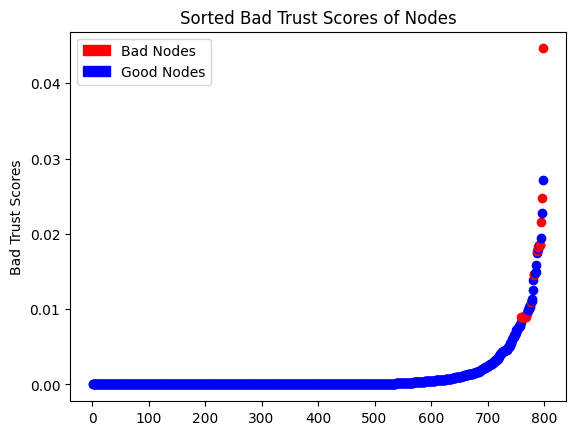

In [26]:
# Plotting the trust ranks if bad node then red else blue
count=0
for i in sortedcolumn:
    count = count + 1
    if i[1] in bad_nodes:
        plt.scatter(count, float(i[0]), color = 'red')
    else:
        plt.scatter(count, float(i[0]), color = 'blue')

    # plt.xlabel('Nodes')
    plt.ylabel('Bad Trust Scores')
    plt.title('Sorted Bad Trust Scores of Nodes')
    # Legend with color and label
    red_patch = mpatches.Patch(color='red', label='Bad Nodes')
    blue_patch = mpatches.Patch(color='blue', label='Good Nodes')
    plt.legend(handles=[red_patch, blue_patch])
    
